# Loading time-series & maps (Diatom Biomass)

## Importing

In [6]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xskillscore as xs

import os
import lzma
import dill

import random

import cmocean.cm as cm
import salishsea_tools.viz_tools as sa_vi


## Plotting (Figure 1 - Biomass)

In [7]:
def plotting_paper_b(dates,targets,predictions,units,boxnames,period,labels,season,r_train,r_train_season,r_test,r_test_season,rms_train,rms_test,name2,inputs_names):

    years = np.unique(dates.year)

    targets = np.reshape(targets,(targets.shape[0]*targets.shape[1],targets.shape[2]), order = 'F')
    predictions = np.reshape(predictions,(predictions.shape[0]*predictions.shape[1],predictions.shape[2]), order = 'F')
    
    targets_masked = np.ma.array(targets)
    predictions_masked = np.ma.array(predictions)

    for year in years:
        targets_masked[(np.where(dates.year==year)[0][-1])] = np.ma.masked
        predictions_masked[(np.where(dates.year==year)[0][-1])] = np.ma.masked

    for year in years:
        targets_masked[(np.where(dates.year==year)[0][-1])] = np.ma.masked
        predictions_masked[(np.where(dates.year==year)[0][-1])] = np.ma.masked

    names = ['(a)','(b)','(c)','(d)','(e)','(f)','(g)','(h)','(i)']

    k,l = 0,0
    fig, ax = plt.subplots(4, 3, figsize=(17, 15), layout='constrained')

    ticks = np.arange(0,len(years)*len(labels),len(labels)/2)
    ticks = np.int16(ticks)
    labels2 = np.tile(labels,len(years))

    test = np.arange(0,len(targets_masked))

    for j in np.arange (0,len(boxnames)):

        ax[k, l].plot(targets_masked[:,j])
        ax[k, l].plot(test[:ticks[-2]-1],predictions_masked[0:ticks[-2]-1,j])
        ax[k, l].plot(test[ticks[-2]:],predictions_masked[ticks[-2]:,j], color = 'tab:red')
        ax[k,l].fill_between((test[0],test[ticks[2]-2]), np.max((targets_masked[:,j],predictions_masked[:,j])), np.min((targets_masked[:,j],predictions_masked[:,j])), alpha=0.3, color='grey')
        ax[k,l].fill_between((test[ticks[4]-1],test[ticks[6]-2]), np.max((targets_masked[:,j],predictions_masked[:,j])), np.min((targets_masked[:,j],predictions_masked[:,j])), alpha=0.3, color='grey')
        ax[k,l].fill_between((test[ticks[-2]-1],test[-1]), np.max((targets_masked[:,j],predictions_masked[:,j])), np.min((targets_masked[:,j],predictions_masked[:,j])), alpha=0.3, color='grey')
        
        ax[k,l].set_xticks(ticks, labels2[ticks], rotation = 20)
        ax[k, l].set_title(boxnames[j] + ' (' + str(inputs_names[j]) + ')', fontsize=12)
        ax[k,l].annotate(names[j], (0.02, 0.9), xycoords='axes fraction', fontsize=14)
        ax[k,l].xaxis.set_tick_params(labelsize=11)
        ax[k,l].yaxis.set_tick_params(labelsize=11)

        ax2 = ax[k, l].secondary_xaxis('bottom')
        ax2.set_xticks(ticks=np.arange(0,len(years)*len(labels),len(labels)), labels=years)
        ax2.tick_params(length=0, pad=35, labelsize=11)

        if l == 0:
            ax[k, l].set_ylabel(units +' (no seasonality)', fontsize=11)

        l=l+1
        if l==3:
            l=0
            k=k+1

    fig.legend(['targets', 'evaluation', 'independent'], ncols=3, fontsize=11)
    fig.suptitle('Mean ' + name2 + ' ' + period, fontsize=15)

    ax[k, l].plot(season)
    ax[k, l].set_xticks(ticks=np.arange(0,len(labels),len(labels)//8+1), labels=labels[np.arange(0,len(labels),len(labels)//8+1)])
    ax[k, l].set_title('Long-term seasonalities (2007-2020)', fontsize=12)
    ax[k, l].set_ylabel(units, fontsize=11)
    ax[k, l].legend(boxnames, ncol=2, fontsize=11)
    ax[k,l].annotate('(j)', (0.95, 0.05), xycoords='axes fraction', fontsize=14)
    ax[k,l].xaxis.set_tick_params(labelsize=11)
    ax[k,l].yaxis.set_tick_params(labelsize=11)

    l = l + 1
    ax[k, l].plot(r_train, label = 'training', marker = '.', ls = ' ', markersize=13)
    ax[k, l].plot(r_test[0], label = 'evaluation', marker = '.', ls = ' ', markersize=13)
    ax[k, l].plot(r_test[1], label = 'independent', marker = '.', ls = ' ', markersize=13)
    ax[k, l].plot(r_train_season, label = 'training (no seasonality)', marker = '.', ls = ' ', markersize=13)
    ax[k, l].plot(r_test_season[0], label = 'evaluation (no seasonality)', marker = '.', ls = '', markersize=13)
    ax[k, l].plot(r_test_season[1], label = 'independent (no seasonality)', marker = '.', ls = '', markersize=13)
    ax[k, l].set_xticks(ticks = np.arange(0, len(boxnames)), labels=boxnames)
    ax[k, l].set_title('Correlation coefficients', fontsize=12)
    ax[k, l].legend(ncols=2, fontsize=11)
    ax[k,l].annotate('(k)', (0.94, 0.15), xycoords='axes fraction', fontsize=14)
    ax[k, l].set_xlabel('Sub-regions', fontsize=11)
    ax[k,l].xaxis.set_tick_params(labelsize=11)
    ax[k,l].yaxis.set_tick_params(labelsize=11)

    l = l + 1
    ax[k, l].plot(rms_train, label = 'training', marker = '.', ls = ' ', markersize=13)
    ax[k, l].plot(rms_test[0], label = 'evaluation', marker = '.', ls = ' ', markersize=13)
    ax[k, l].plot(rms_test[1], label = 'independent', marker = '.', ls = ' ', markersize=13)
    ax[k, l].set_xticks(ticks = np.arange(0, len(boxnames)), labels=boxnames)
    ax[k, l].set_ylabel('[%]', fontsize=11)
    ax[k, l].set_title('Root mean square errors', fontsize=12)
    ax[k, l].legend(fontsize=11)
    ax[k,l].annotate('(l)', (0.95, 0.05), xycoords='axes fraction', fontsize=14)
    ax[k, l].set_xlabel('Sub-regions', fontsize=11)
    ax[k,l].xaxis.set_tick_params(labelsize=11)
    ax[k,l].yaxis.set_tick_params(labelsize=11)
    

## Plotting (Figure 1 - Production Rates)

In [8]:
def plotting_paper_pr(dates,targets,predictions,units,boxnames,period,labels,season,r_train,r_train_season,r_test,r_test_season,rms_train,rms_test,name2):

    years = np.unique(dates.year)

    targets = targets.transpose()
    predictions = predictions.transpose()
    
    targets_masked = np.ma.array(targets)
    predictions_masked = np.ma.array(predictions)

    for year in years:
        targets_masked[(np.where(dates.year==year)[0][-1])] = np.ma.masked
        predictions_masked[(np.where(dates.year==year)[0][-1])] = np.ma.masked

    names = ['(a)','(b)','(c)','(d)','(e)','(f)','(g)','(h)','(i)']

    k,l = 0,0
    fig, ax = plt.subplots(4, 3, figsize=(17, 15), layout='constrained')

    ticks = np.arange(0,len(years)*len(labels),len(labels)/2)
    ticks = np.int16(ticks)
    labels2 = np.tile(labels,len(years))

    test = np.arange(0,len(targets_masked))

    for j in np.arange (0,len(boxnames)):

        ax[k, l].plot(targets_masked[:,j])
        ax[k, l].plot(test[:ticks[-2]-1],predictions_masked[0:ticks[-2]-1,j])
        ax[k, l].plot(test[ticks[-2]:],predictions_masked[ticks[-2]:,j], color = 'tab:red')
        ax[k,l].fill_between((test[0],test[ticks[2]-2]), np.max((targets_masked[:,j],predictions_masked[:,j])), np.min((targets_masked[:,j],predictions_masked[:,j])), alpha=0.3, color='grey')
        ax[k,l].fill_between((test[ticks[4]-1],test[ticks[6]-2]), np.max((targets_masked[:,j],predictions_masked[:,j])), np.min((targets_masked[:,j],predictions_masked[:,j])), alpha=0.3, color='grey')
        ax[k,l].fill_between((test[ticks[-2]-1],test[-1]), np.max((targets_masked[:,j],predictions_masked[:,j])), np.min((targets_masked[:,j],predictions_masked[:,j])), alpha=0.3, color='grey')
        
        ax[k,l].set_xticks(ticks, labels2[ticks], rotation = 20)
        ax[k, l].set_title(boxnames[j], fontsize=12)
        ax[k,l].annotate(names[j], (0.02, 0.9), xycoords='axes fraction', fontsize=14)
        ax[k,l].xaxis.set_tick_params(labelsize=11)
        ax[k,l].yaxis.set_tick_params(labelsize=11)

        ax2 = ax[k, l].secondary_xaxis('bottom')
        ax2.set_xticks(ticks=np.arange(0,len(years)*len(labels),len(labels)), labels=years)
        ax2.tick_params(length=0, pad=35, labelsize=11)

        if l == 0:
            ax[k, l].set_ylabel(units +' (no seasonality)', fontsize=11)

        l=l+1
        if l==3:
            l=0
            k=k+1

    fig.legend(['targets', 'evaluation', 'independent'], ncols=3, fontsize=11)
    fig.suptitle('Mean ' + name2 + ' ' + period, fontsize=15)

    ax[k, l].plot(season)
    ax[k, l].set_xticks(ticks=np.arange(0,len(labels),len(labels)//8+1), labels=labels[np.arange(0,len(labels),len(labels)//8+1)])
    ax[k, l].set_title('Long-term seasonalities (2007-2020)', fontsize=12)
    ax[k, l].set_ylabel(units, fontsize=11)
    ax[k, l].legend(boxnames, ncol=2, fontsize=11)
    ax[k,l].annotate('(j)', (0.95, 0.05), xycoords='axes fraction', fontsize=14)
    ax[k,l].xaxis.set_tick_params(labelsize=11)
    ax[k,l].yaxis.set_tick_params(labelsize=11)

    l = l + 1
    ax[k, l].plot(r_train, label = 'training', marker = '.', ls = ' ', markersize=13)
    ax[k, l].plot(r_test[0], label = 'evaluation', marker = '.', ls = ' ', markersize=13)
    ax[k, l].plot(r_test[1], label = 'independent', marker = '.', ls = ' ', markersize=13)
    ax[k, l].plot(r_train_season, label = 'training (no seasonality)', marker = '.', ls = ' ', markersize=13)
    ax[k, l].plot(r_test_season[0], label = 'evaluation (no seasonality)', marker = '.', ls = '', markersize=13)
    ax[k, l].plot(r_test_season[1], label = 'independent (no seasonality)', marker = '.', ls = '', markersize=13)
    ax[k, l].set_xticks(ticks = np.arange(0, len(boxnames)), labels=boxnames)
    ax[k, l].set_title('Correlation coefficients', fontsize=12)
    ax[k, l].legend(fontsize=11, ncols=2)
    ax[k,l].annotate('(k)', (0.94, 0.15), xycoords='axes fraction', fontsize=14)
    ax[k, l].set_xlabel('Sub-regions', fontsize=11)
    ax[k,l].xaxis.set_tick_params(labelsize=11)
    ax[k,l].yaxis.set_tick_params(labelsize=11)

    l = l + 1
    ax[k, l].plot(rms_train, label = 'training', marker = '.', ls = ' ', markersize=13)
    ax[k, l].plot(rms_test[0], label = 'evaluation', marker = '.', ls = ' ', markersize=13)
    ax[k, l].plot(rms_test[1], label = 'independent', marker = '.', ls = ' ', markersize=13)
    ax[k, l].set_xticks(ticks = np.arange(0, len(boxnames)), labels=boxnames)
    ax[k, l].set_ylabel('[%]', fontsize=11)
    ax[k, l].set_title('Root mean square errors', fontsize=12)
    ax[k, l].legend(fontsize=11)
    ax[k,l].annotate('(l)', (0.95, 0.05), xycoords='axes fraction', fontsize=14)
    ax[k, l].set_xlabel('Sub-regions', fontsize=11)
    ax[k,l].xaxis.set_tick_params(labelsize=11)
    ax[k,l].yaxis.set_tick_params(labelsize=11)
    

## Plotting (Figure 2)

In [9]:
def plotting_figure2(targets_all,predictions_all,units,dates,r_days,rms_days,labels,period, minim, maxim, name2):

    fig, ax = plt.subplots(1,3, figsize = (17,10), layout ='constrained')
    cmap = plt.get_cmap('cubehelix')
    cmap.set_bad('gray')

    a = targets_all.plot(ax=ax[0], cmap=cmap, vmin = minim, vmax = maxim, cbar_kwargs={'label': name2 + ' ' + units})
    cbar = a.colorbar
    cbar.ax.tick_params(labelsize=11)
    cbar.set_label(label= name2 + ' ' + units , size=11)
    ax[0].set_axis_off()

    a = predictions_all.plot(ax=ax[1], cmap=cmap, vmin = minim, vmax = maxim, cbar_kwargs={'label': name2 + ' ' + units})
    cbar = a.colorbar
    cbar.ax.tick_params(labelsize=11)
    cbar.set_label(label= name2 + ' ' + units , size=11)
    ax[1].set_axis_off()

    a = ((targets_all-predictions_all) / targets_all * 100).plot(ax=ax[2], cmap=cmap, cbar_kwargs={'label': name2 + ' errors' + ' ' + '[%]'})
    cbar = a.colorbar
    cbar.ax.tick_params(labelsize=11)
    cbar.set_label(label= name2 + ' errors' + ' ' + '[%]', size=11)
    ax[2].set_axis_off()

    sa_vi.set_aspect(ax[0])
    sa_vi.set_aspect(ax[1])
    sa_vi.set_aspect(ax[2])

    ax[0].annotate('(a)', (0.02, 0.97), xycoords='axes fraction', fontsize=14)
    ax[1].annotate('(b)', (0.02, 0.97), xycoords='axes fraction', fontsize=14)
    ax[2].annotate('(c)', (0.02, 0.97), xycoords='axes fraction', fontsize=14)

    ax[0].set_title('Targets', fontsize=12)
    ax[1].set_title('Predictions', fontsize=12)
    ax[2].set_title('Targets - Predictions', fontsize=12)

    for i in range (0, 3):
        ax[i].xaxis.set_tick_params(labelsize=11)
        ax[i].yaxis.set_tick_params(labelsize=11)

        ax[i].set_ylabel('y', fontsize=11)
        ax[i].set_xlabel('x', fontsize=11)

    plt.suptitle(name2 + ' daily maps ' +units + ', ' + '(' + str(targets_all.time_counter.dt.date.values) + ')', fontsize=15)

    years = np.unique(dates.year)

    fig, ax = plt.subplots(figsize=(17,6),  layout ='constrained')

    mean_r_days = np.ma.array(r_days)
    mean_rms_days = np.ma.array(rms_days)
    test = np.arange(0,len(mean_r_days))

    ticks = np.arange(0,len(years)*len(labels),len(labels)/2)
    ticks = np.int16(ticks)
    labels2=np.tile(labels,len(years))

    for year in years:
        mean_r_days[(np.where(dates.year==year)[0][-1])] = np.ma.masked
        mean_rms_days[(np.where(dates.year==year)[0][-1])] = np.ma.masked
        
    ax.plot(mean_r_days, marker = '.', markersize=10)
    ax.fill_between((test[0],test[ticks[2]-2]), np.max(mean_r_days), alpha=0.3, color='grey')
    ax.fill_between((test[ticks[4]-1],test[ticks[6]-2]), np.max(mean_r_days), alpha=0.3, color='grey')
    ax.fill_between((test[ticks[-2]-1],test[-1]), np.max(mean_r_days), alpha=0.3, color='grey')
    
    ax.annotate('(d)', (0.005, 0.92), xycoords='axes fraction', fontsize=14)

    ax.set_xticks(ticks, labels2[ticks])
    ax.set_ylabel('Daily spatial R', color='tab:blue', fontsize=11)
    ax.xaxis.set_tick_params(labelsize=11)
    ax.yaxis.set_tick_params(labelsize=11)

    ax2 = ax.secondary_xaxis('bottom')
    ax2.set_xticks(ticks=np.arange(0,len(years)*len(labels),len(labels)), labels=years)
    ax2.tick_params(length=0, pad=30)
    ax2.xaxis.set_tick_params(labelsize=11)

    ax3 = ax.twinx()
    ax3.plot(mean_rms_days, marker = '.', color='tab:orange', markersize=10)
    ax3.set_ylabel('Daily spatial RMSE [%]', color='tab:orange', fontsize=11)
    ax3.xaxis.set_tick_params(labelsize=11)
    ax3.yaxis.set_tick_params(labelsize=11)

    plt.suptitle('Daily spatial R and RMSE for ' + name2 + ' ' + period, fontsize=15)
    plt.show()
    

## Loading

In [10]:
name = 'Diatom'
name2 = 'DB'
id = '2'

if 'Production' in name:
    path = '/data/ibougoudis/MOAD/files/results/' + name + '/single_runs/' + name[0:4].lower() + '_pr_hist' + id + '_boxes_f/'

else:
    path = '/data/ibougoudis/MOAD/files/results/' + name + '/single_runs/' + name[0:4].lower() + '_func_reg' + id + '_boxes_s_df/'

with open(path + 'figure1.pkl', 'rb') as f:
    figure1 = dill.load(f)

dates = figure1[0]
targets_test = figure1[1]
predictions_test = figure1[2]
units = figure1[3]
boxnames = figure1[4]
period = figure1[5]
labels = figure1[6]
season_all = figure1[7]
r_train = figure1[8]
r_train_season = figure1[9]
r_test = figure1[10]
r_test_season = figure1[11]
rms_train = figure1[12]
rms_test = figure1[13]

units = '[N mmol $m^{-2}$]'

if 'Production' in name:
    with open(path + 'figure2.pkl', 'rb') as f:
        figure2 = dill.load(f)

    targets_all = figure2[0]
    predictions_all = figure2[1]
    units = figure2[2]
    dates = figure2[3]
    r_days = figure2[4]
    rms_days = figure2[5]
    labels = figure2[6]
    period = figure2[7]
    minim = figure2[8]
    maxim = figure2[9]
    units = '[$s^{-1}$]'

if name == 'Diatom':
    inputs_names = [('SWR, TP'), ('SWR'), ('SWR, TP'), ('SWR, TP'), ('SWR, LWR'), ('SWR, AT'), ('SWR, AT'), ('SWR'), ('SWR, LWR')]

elif name == 'Flagellate':
    inputs_names = [('SWR'), ('SWR, AP, AT'), ('SWR, AT'), ('SWR, AP'), ('SWR, AP, AT'), ('AP, AT'), ('SWR, AP, AT'), ('SWR, AT'), ('SWR, SH')]


## Figure 1

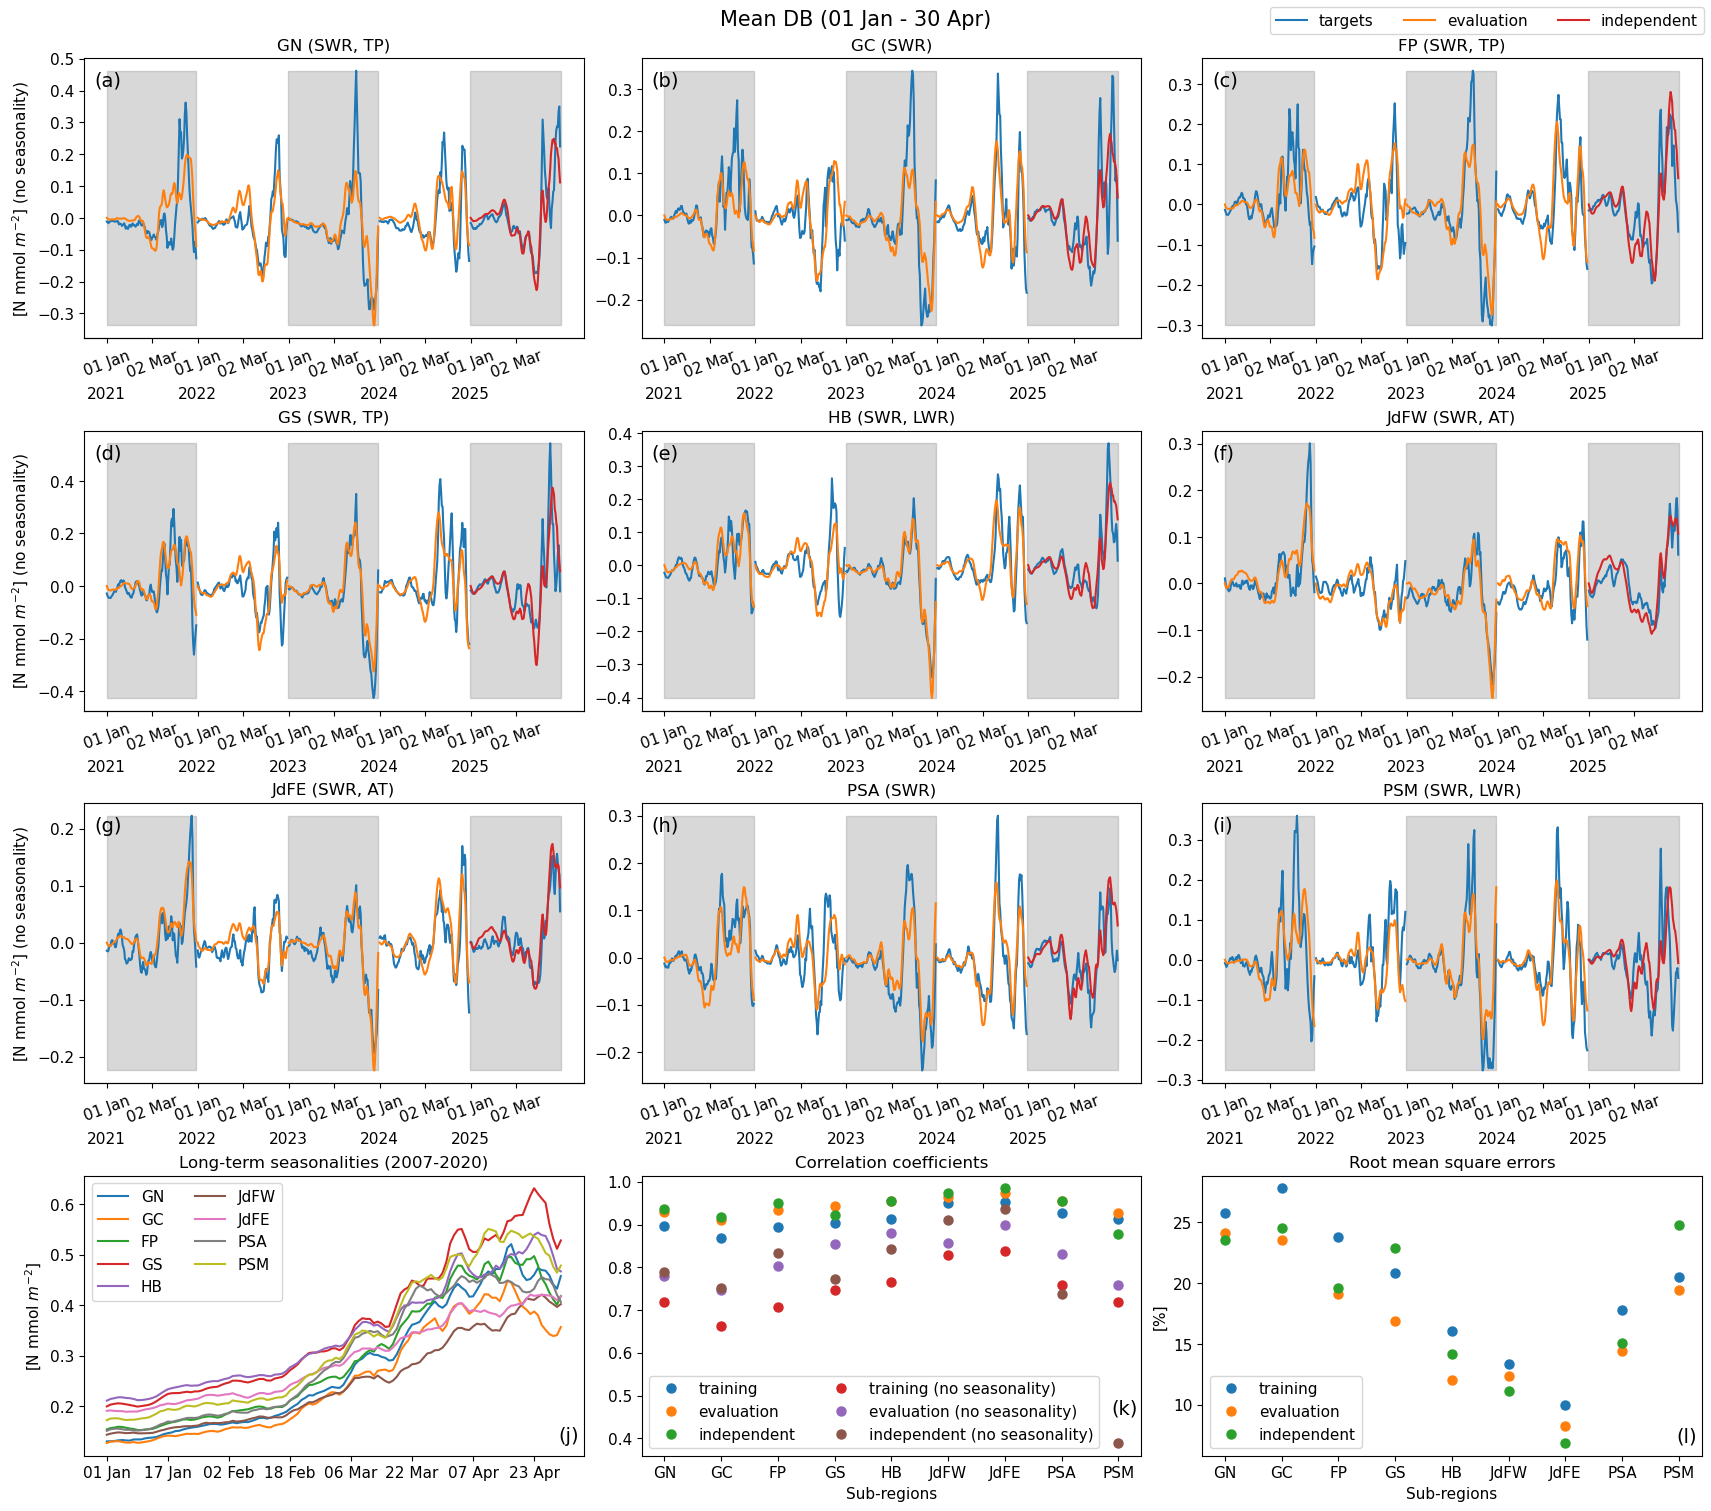

In [11]:
if 'Production' in name:
    plotting_paper_pr(dates,targets_test,predictions_test,units,boxnames,period,labels,season_all.transpose(),
        r_train,r_train_season,r_test,r_test_season,rms_train,rms_test,name2)

else:
    plotting_paper_b(dates,targets_test,predictions_test,units,boxnames,period,labels,season_all,
        r_train,r_train_season,r_test,r_test_season,rms_train,rms_test,name2,inputs_names)
    

## Figure 2

In [12]:
if 'Production' in name:
    plotting_figure2(targets_all,predictions_all,units,dates,r_days,rms_days,labels,period, minim, maxim,name2)
